In [1]:

import jax
import clrs
import numpy as np

rng = np.random.RandomState(1234)
rng_key = jax.random.PRNGKey(rng.randint(2 ** 32))
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

2023-06-01 23:03:56.083856: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/anders/miniconda3/envs/clrs/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
def samplers(sampler_spec, **kwargs):
    batch_size = sampler_spec.get('batch_size', 1)
    num_samples = sampler_spec['num_samples']
    if batch_size > num_samples:
        batch_size = num_samples

    def _iterate_sampler(sampler, batch_size):
        while True:
            yield sampler.next(batch_size)

    sampler, spec = clrs.build_sampler(
        name = 'simplified_min_sum',
        sampler_spec = sampler_spec,
        **kwargs)  # number of nodes

    sampler = _iterate_sampler(sampler, batch_size = batch_size)
    return sampler, spec

In [3]:
# If you don't want BipartiteMatching, just pass empty generator list and
# length separately


def gen_sym_matrix(n, m):
    A = np.random.rand(n, m)
    B = np.zeros((n + m, n + m))
    B[:n, n:] = A
    B[n:, :n] = A.T
    return B

def optimal_matching_value(A):
    row, col = linear_sum_assignment(A, maximize=True)
    return A[row, col].sum() / 2

def greedy_matching_value(A):
    matching_weight = 0
    seen = set()
    # Get the indices of the weights in highest to lowest order (hence the negative sign), inspired by https://stackoverflow.com/questions/30577375/have-numpy-argsort-return-an-array-of-2d-indices
    indices = np.dstack(np.unravel_index(np.argsort(- A.ravel()), A.shape))

    for index in indices[0]:
        if index[0] not in seen and index[1] not in seen:
            matching_weight += A[tuple(index)]
            seen.add(index[0])
            seen.add(index[1])

    return matching_weight

def greedy_test(sampler, trials):
    ratios = []
    for _ in range(trials):
        A = next(sampler)[0][0][1].data[0]
        ratios.append(greedy_matching_value(A) / optimal_matching_value(A))
    return ratios


In [37]:
ER_spec_1 = {
    'num_samples': 1000,
    'batch_size': 1,
    'schematics': [
        {
            'generator': 'ER',
            'proportion': 1,
            'length': 64,
            'kwargs': {'p': 0.5, 'low': 0, 'high': 1, 'weighted': True}
        }
    ]
}

ER_spec_2 = {
    'num_samples': 1000,
    'batch_size': 1,
    'schematics': [
        {
            'generator': 'ER',
            'proportion': 1,
            'length': 16,
            'length2': 48,
            'kwargs': {'p': 0.5, 'low': 0, 'high': 1, 'weighted': True}
        }
    ]
}

BA_spec_1 = {
    'num_samples': 1000,
    'batch_size': 1,
    'schematics': [
        {
            'generator': 'ER',
            'proportion': 1,
            'length': 64,
            'kwargs': {'ba_param': 5, 'low': 0, 'high': 1, 'weighted': True}
        }
    ]
}



ER_sampler_1, _ = samplers(ER_spec_1)
ER_sampler_2, _ = samplers(ER_spec_2)
BA_sampler_1, _ = samplers(BA_spec_1)




In [8]:
GEO_spec_1 = {
    'num_samples': 1000,
    'batch_size': 1,
    'schematics': [
        {
            'generator': 'GEOMETRIC',
            'proportion': 1,
            'length': 64,
            'kwargs': {'treshold': 0, 'scaling': 1 / np.sqrt(2), 'partition': 1, 'power': 1}
        }
    ]
}
GEO_sampler_1, _ = samplers(GEO_spec_1)

In [9]:
GEO_spec_2 = {
    'num_samples': 1000,
    'batch_size': 1,
    'schematics': [
        {
            'generator': 'GEOMETRIC',
            'proportion': 1,
            'length': 16,
            'length2': 48,
            'kwargs': {'treshold': 0, 'scaling': 1 / np.sqrt(2), 'partition': 1, 'power': 1}
        }
    ]
}
GEO_sampler_2, _ = samplers(GEO_spec_2)

In [33]:
BA_spec_2 = {
    'num_samples': 1000,
    'batch_size': 1,
    'schematics': [
        {
            'generator': 'GEOMETRIC',
            'proportion': 1,
            'length': 16,
            'length2': 48,
            'kwargs': {'treshold': 0, 'scaling': 1 / np.sqrt(2)}
        }
    ]
}
BA_sampler_2, _ = samplers(BA_spec_2)

In [13]:
RS_spec_1 = {
    'num_samples': 100,
    'batch_size': 1,
    'schematics': [
        {
            'generator': 'RIDESHARE',
            'proportion': 1,
            'length': 64,
            'kwargs': {}
        }
    ]
}
RS_sampler_1, _ = samplers(RS_spec_1)

before: 902.0, actual (n,m): (56, 114)
after: 127.0


before: 1092.0, actual (n,m): (56, 114)
after: 147.0


before: 1096.0, actual (n,m): (56, 114)
after: 172.0


before: 1302.0, actual (n,m): (56, 114)
after: 273.0


before: 964.0, actual (n,m): (56, 114)
after: 161.0


before: 1270.0, actual (n,m): (56, 114)
after: 198.0


before: 1141.0, actual (n,m): (56, 114)
after: 200.0


before: 1056.0, actual (n,m): (56, 114)
after: 146.0


before: 1190.0, actual (n,m): (56, 114)
after: 212.0


before: 995.0, actual (n,m): (56, 114)
after: 168.0


before: 1178.0, actual (n,m): (56, 114)
after: 212.0


before: 1185.0, actual (n,m): (56, 114)
after: 175.0


before: 1270.0, actual (n,m): (56, 114)
after: 153.0


before: 1218.0, actual (n,m): (56, 114)
after: 216.0


before: 1267.0, actual (n,m): (56, 114)
after: 173.0


before: 1085.0, actual (n,m): (56, 114)
after: 175.0


before: 1188.0, actual (n,m): (56, 114)
after: 190.0


before: 1246.0, actual (n,m): (56, 114)
after: 188.0


before: 1049.0, actual (n,m): (56, 114)
after: 164.0


before: 1155.0, actual (n,m): (56, 114)
after: 153.0


before: 1053.0, actual (n,m): (56, 114)
after: 151.0


before: 1269.0, actual (n,m): (56, 114)
after: 173.0


before: 1188.0, actual (n,m): (56, 114)
after: 185.0


before: 1125.0, actual (n,m): (56, 114)
after: 197.0


before: 1070.0, actual (n,m): (56, 114)
after: 165.0


before: 1010.0, actual (n,m): (56, 114)
after: 176.0


before: 1087.0, actual (n,m): (56, 114)
after: 168.0


before: 1081.0, actual (n,m): (56, 114)
after: 149.0


before: 1256.0, actual (n,m): (56, 114)
after: 174.0


before: 1191.0, actual (n,m): (56, 114)
after: 195.0


before: 1264.0, actual (n,m): (56, 114)
after: 213.0


before: 1248.0, actual (n,m): (56, 114)
after: 199.0


before: 1111.0, actual (n,m): (56, 114)
after: 158.0


before: 960.0, actual (n,m): (56, 114)
after: 156.0


before: 1303.0, actual (n,m): (56, 114)
after: 230.0


before: 1089.0, actual (n,m): (56, 114)
after: 161.0


before: 1325.0, actual (n,m): (56, 114)
after: 228.0


before: 1411.0, actual (n,m): (56, 114)
after: 204.0


before: 1181.0, actual (n,m): (56, 114)
after: 166.0


before: 1132.0, actual (n,m): (56, 114)
after: 155.0


before: 1017.0, actual (n,m): (56, 114)
after: 151.0


before: 1062.0, actual (n,m): (56, 114)
after: 153.0


before: 1051.0, actual (n,m): (56, 114)
after: 151.0


before: 957.0, actual (n,m): (56, 114)
after: 190.0


before: 1073.0, actual (n,m): (56, 114)
after: 173.0


before: 1071.0, actual (n,m): (56, 114)
after: 150.0


before: 1153.0, actual (n,m): (56, 114)
after: 173.0


before: 1141.0, actual (n,m): (56, 114)
after: 186.0


before: 1076.0, actual (n,m): (56, 114)
after: 166.0


before: 1315.0, actual (n,m): (56, 114)
after: 191.0


before: 1071.0, actual (n,m): (56, 114)
after: 176.0


before: 1058.0, actual (n,m): (56, 114)
after: 141.0


before: 1025.0, actual (n,m): (56, 114)
after: 159.0


before: 1102.0, actual (n,m): (56, 114)
after: 162.0


before: 923.0, actual (n,m): (56, 114)
after: 141.0


before: 1072.0, actual (n,m): (56, 114)
after: 192.0


before: 1160.0, actual (n,m): (56, 114)
after: 167.0


before: 1149.0, actual (n,m): (56, 114)
after: 182.0


before: 1144.0, actual (n,m): (56, 114)
after: 199.0


before: 1163.0, actual (n,m): (56, 114)
after: 162.0


before: 1287.0, actual (n,m): (56, 114)
after: 196.0


before: 1049.0, actual (n,m): (56, 114)
after: 153.0


before: 1003.0, actual (n,m): (56, 114)
after: 153.0


before: 1211.0, actual (n,m): (56, 114)
after: 193.0


before: 1040.0, actual (n,m): (55, 114)
after: 161.0


before: 1002.0, actual (n,m): (56, 114)
after: 160.0


before: 1097.0, actual (n,m): (56, 114)
after: 177.0


before: 1135.0, actual (n,m): (56, 114)
after: 191.0


before: 1074.0, actual (n,m): (56, 114)
after: 173.0


before: 1173.0, actual (n,m): (56, 114)
after: 167.0


before: 918.0, actual (n,m): (56, 114)
after: 129.0


before: 1114.0, actual (n,m): (56, 114)
after: 175.0


before: 1152.0, actual (n,m): (56, 114)
after: 173.0


before: 1268.0, actual (n,m): (56, 114)
after: 163.0


before: 1251.0, actual (n,m): (56, 114)
after: 229.0


before: 1198.0, actual (n,m): (56, 114)
after: 200.0


before: 1270.0, actual (n,m): (56, 114)
after: 218.0


before: 1076.0, actual (n,m): (56, 114)
after: 172.0


before: 1033.0, actual (n,m): (56, 114)
after: 166.0


before: 1062.0, actual (n,m): (56, 114)
after: 152.0


before: 1346.0, actual (n,m): (56, 114)
after: 219.0


before: 990.0, actual (n,m): (56, 114)
after: 133.0


before: 1083.0, actual (n,m): (56, 114)
after: 149.0


before: 1264.0, actual (n,m): (56, 114)
after: 252.0


before: 1176.0, actual (n,m): (56, 114)
after: 165.0


before: 1176.0, actual (n,m): (56, 114)
after: 171.0


before: 1085.0, actual (n,m): (56, 114)
after: 158.0


before: 1067.0, actual (n,m): (55, 114)
after: 186.0


before: 1148.0, actual (n,m): (56, 114)
after: 173.0


before: 1103.0, actual (n,m): (56, 114)
after: 191.0


before: 1164.0, actual (n,m): (56, 114)
after: 180.0


before: 1123.0, actual (n,m): (56, 114)
after: 152.0


before: 1084.0, actual (n,m): (56, 114)
after: 180.0


before: 1168.0, actual (n,m): (56, 114)
after: 176.0


before: 1061.0, actual (n,m): (56, 114)
after: 112.0


before: 1209.0, actual (n,m): (56, 114)
after: 231.0


before: 1075.0, actual (n,m): (56, 114)
after: 178.0


before: 1197.0, actual (n,m): (56, 114)
after: 210.0


before: 1117.0, actual (n,m): (56, 114)
after: 177.0
before: 1176.0, actual (n,m): (56, 114)
after: 170.0


In [14]:
RS_spec_2 = {
    'num_samples': 100,
    'batch_size': 1,
    'schematics': [
        {
            'generator': 'RIDESHARE',
            'proportion': 1,
            'length': 16,
            'length2': 48,
            'kwargs': {}
        }
    ]
}
RS_sampler_2, _ = samplers(RS_spec_2)

before: 51.0, actual (n,m): (13, 27)
after: 6.0


before: 68.0, actual (n,m): (13, 27)
after: 9.0


before: 68.0, actual (n,m): (13, 27)
after: 17.0


before: 51.0, actual (n,m): (12, 27)
after: 9.0


before: 64.0, actual (n,m): (13, 27)
after: 9.0


before: 67.0, actual (n,m): (13, 27)
after: 10.0


before: 69.0, actual (n,m): (13, 27)
after: 10.0


before: 73.0, actual (n,m): (13, 27)
after: 16.0


before: 66.0, actual (n,m): (13, 27)
after: 8.0


before: 72.0, actual (n,m): (13, 27)
after: 8.0


before: 66.0, actual (n,m): (13, 27)
after: 8.0


before: 83.0, actual (n,m): (13, 27)
after: 13.0


before: 63.0, actual (n,m): (13, 27)
after: 11.0


before: 65.0, actual (n,m): (13, 27)
after: 10.0


before: 77.0, actual (n,m): (13, 26)
after: 16.0


before: 58.0, actual (n,m): (13, 27)
after: 14.0


before: 94.0, actual (n,m): (13, 27)
after: 13.0


before: 77.0, actual (n,m): (13, 27)
after: 10.0


before: 58.0, actual (n,m): (12, 27)
after: 12.0


before: 85.0, actual (n,m): (13, 27)
after: 14.0


before: 63.0, actual (n,m): (13, 27)
after: 9.0


before: 58.0, actual (n,m): (13, 27)
after: 10.0


before: 75.0, actual (n,m): (13, 27)
after: 6.0


before: 90.0, actual (n,m): (13, 27)
after: 17.0


before: 87.0, actual (n,m): (13, 27)
after: 13.0


before: 49.0, actual (n,m): (13, 27)
after: 9.0


before: 61.0, actual (n,m): (13, 26)
after: 10.0


before: 75.0, actual (n,m): (13, 27)
after: 20.0


before: 62.0, actual (n,m): (13, 27)
after: 14.0


before: 63.0, actual (n,m): (11, 27)
after: 16.0


before: 60.0, actual (n,m): (13, 27)
after: 12.0


before: 69.0, actual (n,m): (13, 27)
after: 12.0


before: 72.0, actual (n,m): (13, 27)
after: 9.0


before: 71.0, actual (n,m): (13, 27)
after: 16.0


before: 63.0, actual (n,m): (13, 27)
after: 10.0


before: 80.0, actual (n,m): (13, 27)
after: 13.0


before: 64.0, actual (n,m): (13, 27)
after: 11.0


before: 85.0, actual (n,m): (13, 27)
after: 15.0


before: 63.0, actual (n,m): (13, 27)
after: 13.0


before: 67.0, actual (n,m): (13, 27)
after: 16.0


before: 93.0, actual (n,m): (13, 27)
after: 17.0


before: 71.0, actual (n,m): (12, 27)
after: 16.0


before: 58.0, actual (n,m): (13, 26)
after: 9.0


before: 67.0, actual (n,m): (13, 27)
after: 8.0


before: 52.0, actual (n,m): (13, 27)
after: 7.0


before: 61.0, actual (n,m): (13, 27)
after: 12.0


before: 78.0, actual (n,m): (13, 27)
after: 11.0


before: 101.0, actual (n,m): (13, 27)
after: 23.0


before: 72.0, actual (n,m): (13, 27)
after: 11.0


before: 61.0, actual (n,m): (12, 27)
after: 8.0


before: 87.0, actual (n,m): (13, 27)
after: 16.0


before: 78.0, actual (n,m): (13, 27)
after: 14.0


before: 47.0, actual (n,m): (13, 27)
after: 6.0


before: 98.0, actual (n,m): (13, 27)
after: 14.0


before: 73.0, actual (n,m): (13, 24)
after: 16.0


before: 79.0, actual (n,m): (13, 27)
after: 16.0


before: 55.0, actual (n,m): (13, 27)
after: 9.0


before: 63.0, actual (n,m): (13, 27)
after: 9.0


before: 88.0, actual (n,m): (13, 27)
after: 19.0


before: 41.0, actual (n,m): (13, 27)
after: 5.0


before: 80.0, actual (n,m): (13, 27)
after: 23.0


before: 40.0, actual (n,m): (13, 27)
after: 12.0


before: 74.0, actual (n,m): (13, 27)
after: 20.0


before: 83.0, actual (n,m): (13, 27)
after: 11.0


before: 54.0, actual (n,m): (13, 27)
after: 7.0


before: 52.0, actual (n,m): (13, 27)
after: 5.0


before: 63.0, actual (n,m): (13, 26)
after: 12.0


before: 60.0, actual (n,m): (13, 27)
after: 10.0


before: 59.0, actual (n,m): (12, 27)
after: 6.0


before: 65.0, actual (n,m): (13, 27)
after: 9.0


before: 44.0, actual (n,m): (13, 26)
after: 9.0


before: 73.0, actual (n,m): (13, 27)
after: 14.0


before: 73.0, actual (n,m): (13, 27)
after: 17.0


before: 61.0, actual (n,m): (13, 27)
after: 9.0


before: 52.0, actual (n,m): (13, 27)
after: 7.0


before: 39.0, actual (n,m): (13, 26)
after: 13.0


before: 61.0, actual (n,m): (13, 27)
after: 14.0


before: 57.0, actual (n,m): (13, 27)
after: 11.0


before: 84.0, actual (n,m): (13, 26)
after: 8.0


before: 59.0, actual (n,m): (13, 27)
after: 11.0


before: 71.0, actual (n,m): (13, 27)
after: 8.0


before: 56.0, actual (n,m): (13, 27)
after: 11.0


before: 78.0, actual (n,m): (13, 27)
after: 15.0


before: 65.0, actual (n,m): (13, 25)
after: 6.0


before: 71.0, actual (n,m): (13, 27)
after: 13.0


before: 72.0, actual (n,m): (12, 27)
after: 10.0


before: 46.0, actual (n,m): (13, 26)
after: 6.0


before: 55.0, actual (n,m): (12, 27)
after: 9.0


before: 65.0, actual (n,m): (12, 27)
after: 15.0


before: 85.0, actual (n,m): (12, 27)
after: 13.0


before: 85.0, actual (n,m): (13, 27)
after: 10.0


before: 63.0, actual (n,m): (13, 27)
after: 11.0


before: 47.0, actual (n,m): (13, 27)
after: 10.0


before: 80.0, actual (n,m): (13, 27)
after: 15.0


before: 63.0, actual (n,m): (13, 26)
after: 10.0


before: 78.0, actual (n,m): (13, 27)
after: 14.0


before: 81.0, actual (n,m): (13, 27)
after: 12.0


before: 69.0, actual (n,m): (13, 27)
after: 11.0


before: 70.0, actual (n,m): (13, 27)
after: 9.0
before: 56.0, actual (n,m): (13, 27)
after: 11.0


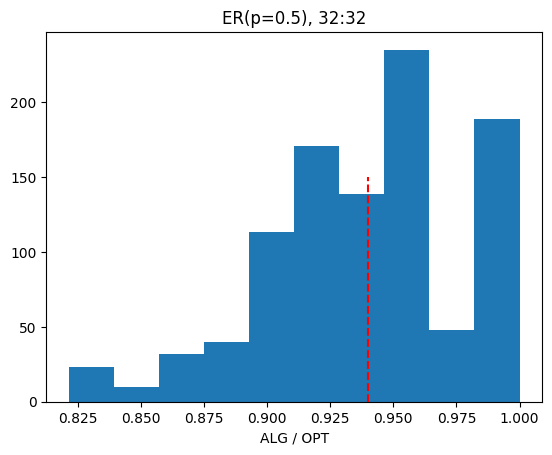

Mean: 0.9397849242648391, Standard deviation: 0.042866155188594345


In [16]:
ratios = greedy_test(RS_sampler_1, trials=1000)
mean = np.mean(ratios)
std = np.std(ratios)
plt.hist(ratios, bins=10)
plt.vlines(x=mean, ymin=0, ymax=150, linestyle='dashed', color='red')
plt.xlabel('ALG / OPT')
plt.title('ER(p=0.5), 32:32')
plt.show()
print(f'Mean: {mean}, Standard deviation: {std}')

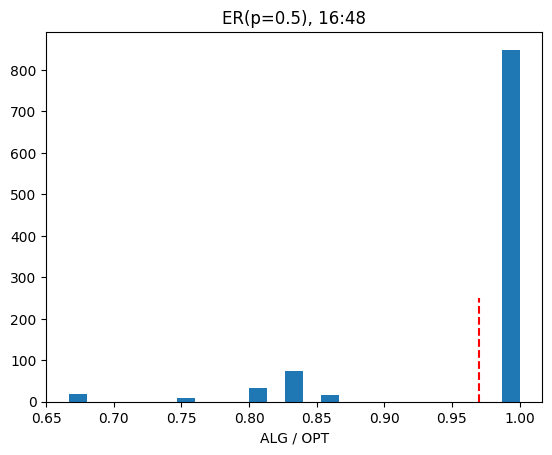

Mean: 0.9702476190476191, Standard deviation: 0.07385190733953372


In [17]:
ratios = greedy_test(RS_sampler_2, trials=1000)
mean = np.mean(ratios)
std = np.std(ratios)
plt.hist(ratios, bins=25)
plt.vlines(x=mean, ymin=0, ymax=250, linestyle='dashed', color='red')
plt.xlabel('ALG / OPT')
plt.title('ER(p=0.5), 16:48')
plt.show()
print(f'Mean: {mean}, Standard deviation: {std}')

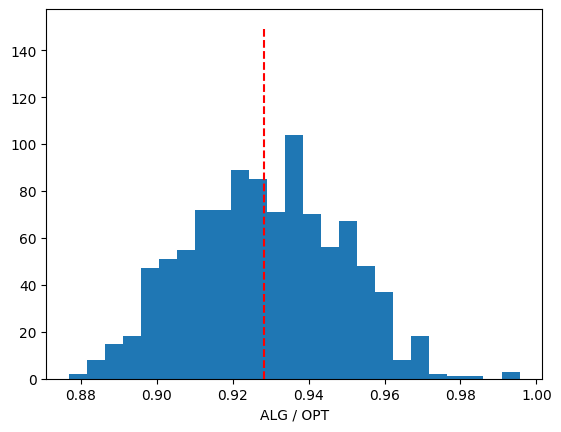

Mean: 0.9283429457920056, Standard deviation: 0.019891534550081896


In [27]:
ratios = greedy_test(BA_sampler_1, trials=1000)
mean = np.mean(ratios)
std = np.std(ratios)
plt.hist(ratios, bins=25)
plt.vlines(x=mean, ymin=0, ymax=150, linestyle='dashed', color='red')
plt.xlabel('ALG / OPT')
plt.show()
print(f'Mean: {mean}, Standard deviation: {std}')

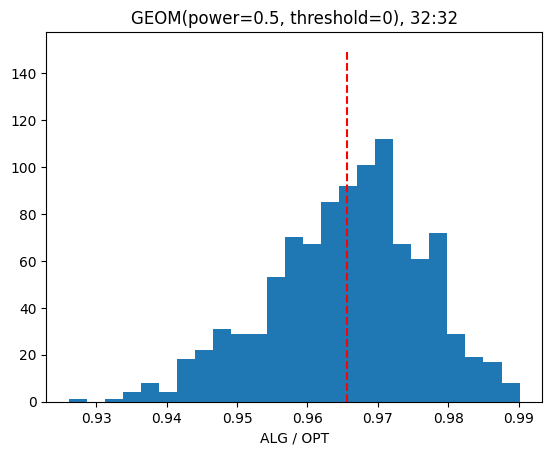

Mean: 0.9656409966942822, Standard deviation: 0.010876531069067514


In [10]:
ratios = greedy_test(GEO_sampler_1, trials=1000)
mean = np.mean(ratios)
std = np.std(ratios)
plt.hist(ratios, bins=25)
plt.title('GEOM(power=0.5, threshold=0), 32:32')
plt.vlines(x=mean, ymin=0, ymax=150, linestyle='dashed', color='red')
plt.xlabel('ALG / OPT')
plt.show()
print(f'Mean: {mean}, Standard deviation: {std}')

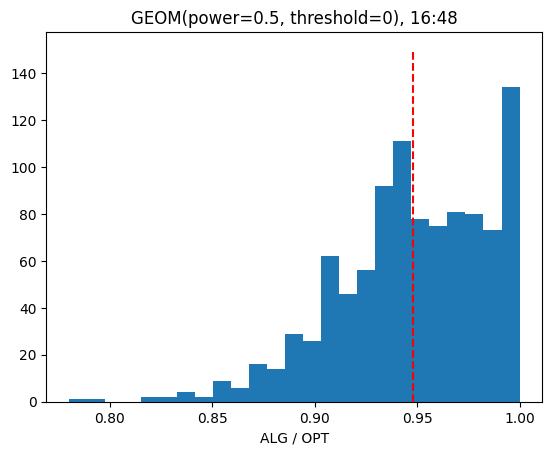

Mean: 0.9478375497819377, Standard deviation: 0.03688796769778092


In [11]:
ratios = greedy_test(GEO_sampler_2, trials=1000)
mean = np.mean(ratios)
std = np.std(ratios)
plt.hist(ratios, bins=25)
plt.title('GEOM(power=0.5, threshold=0), 16:48')
plt.vlines(x=mean, ymin=0, ymax=150, linestyle='dashed', color='red')
plt.xlabel('ALG / OPT')
plt.show()
print(f'Mean: {mean}, Standard deviation: {std}')

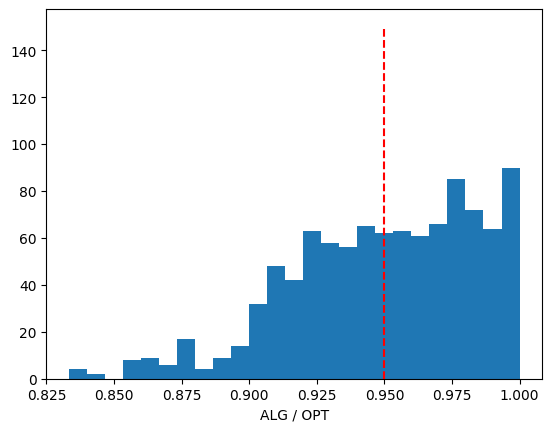

Mean: 0.9498308071370594, Standard deviation: 0.03448360587568475


In [34]:
ratios = greedy_test(BA_sampler_2, trials=1000)
mean = np.mean(ratios)
std = np.std(ratios)
plt.hist(ratios, bins=25)
plt.vlines(x=mean, ymin=0, ymax=150, linestyle='dashed', color='red')
plt.xlabel('ALG / OPT')
plt.show()
print(f'Mean: {mean}, Standard deviation: {std}')

In [12]:



def matching_value(samples, predictions, partial = False, match_rest = False, opt_scipy = False):
    features = samples.features
    gt_matchings = samples.outputs[0].data
    # inputs for the matrix A are at index 1 (see spec.py)
    data = features.inputs[1].data
    masks = features.inputs[3].data
    pred_accuracy = 0
    greedy_accuracy = 0

    #TODO remove
    def _add_uniform_weights(adj, low, high):
        n, m = adj.shape
        weights = np.random.uniform(
            low=low, high=high, size=(n, m)
        )
        return adj * high + low

    # Iterating over all the samples
    for i in range(data.shape[0]):

        if opt_scipy:
            row_ind, col_ind = linear_sum_assignment(data[i], maximize = True)
            max_weight = data[i][row_ind, col_ind].sum() / 2  #TODO why /2
        else:
            max_weight = compute_greedy_matching_weight(i, data, masks, gt_matchings[i])

        predicted_matching = predictions["match"].data[i]

        if partial:
            preds_weight = compute_partial_matching_weight(i, data, masks, predicted_matching)
            print(f"opt: {max_weight}, greedy learned: {preds_weight}")
        else:
            preds_weight = compute_greedy_matching_weight(i, data, masks, predicted_matching, match_rest = match_rest)
            print(f"opt: {max_weight}, partial: {preds_weight}")

        # assert preds_weight <= max_weight
        greedy_matching_weight = naive_greedy(i, data, masks)
        print(f"Naive greedy: {greedy_matching_weight}")
        greedy_accuracy += greedy_matching_weight / max_weight
        pred_accuracy += preds_weight / max_weight

    return pred_accuracy / data.shape[0], greedy_accuracy / data.shape[0]

def naive_greedy(i, data, masks):
    """Computes a matching greedily by, for each node, adding the maximum neighbor that
    hasn't yet been added to the matching"""

    matching_weight = 0
    A = data[i]
    buyers_mask = masks[i]
    n = int(np.sum(buyers_mask))
    # At the start, all the right hand side values are possible matches
    matching_mask = np.full(A.shape[0], True)

    # for buyer in range(n):
    #     # Checking if there are more elements to match (if more buyers than goods)
    #     if A[buyer, matching_mask].shape[0] != 0:
    #         matching_weight += np.max(A[buyer, matching_mask])
    #         # Recovering the index of the maximum, inspired by http://seanlaw.github.io/2015/09/10/numpy-argmin-with-a-condition/
    #         subset_idx = np.argmax(A[buyer, matching_mask])
    #         good = np.arange(A.shape[1])[matching_mask][subset_idx]
    #         # The corresponding good cannot be used anymore
    #         matching_mask[good] = False

    # Second method of computing a greedy matching
    # Set of vertices already matched
    matching = set()
    # Get the indices of the weights in highest to lowest order (hence the negative sign), inspired by https://stackoverflow.com/questions/30577375/have-numpy-argsort-return-an-array-of-2d-indices
    indices = np.dstack(np.unravel_index(np.argsort(- A.ravel()), A.shape))
    for index in indices[0]:
        if index[0] not in matching and index[1] not in matching:
            matching_weight += A[tuple(index)]
            matching.add(index[0])
            matching.add(index[1])


    return matching_weight




def compute_greedy_matching_weight(i, data, masks, matching, match_rest = False):
    matching_weight = 0
    A = data[i]
    buyers_mask = masks[i]
    n = int(np.sum(buyers_mask))
    goods_mask = 1 - buyers_mask
    m = int(np.sum(goods_mask))

    # Only consider the matching values for consumers
    matching = np.where(goods_mask == 1, matching, -1)
    unmatched_goods = set(range(n, n + m))
    unmatched_buyers = set(range(n))

    for buyer in range(n):
        if buyer in matching:
            # If several goods point to the same buyer, keep the one with maximum weight
            mask = matching == buyer
            matching_weight += np.max(A[buyer, mask])
            # Recovering the index of the maximum, inspired by http://seanlaw.github.io/2015/09/10/numpy-argmin-with-a-condition/
            subset_idx = np.argmax(A[buyer, mask])
            good = np.arange(A.shape[1])[mask][subset_idx]
            unmatched_goods.remove(good)
            unmatched_buyers.remove(buyer)

    if match_rest and len(unmatched_goods) > 0 and len(unmatched_buyers) > 0:
        # Compute optimal matching on the remaining unmatched nodes
        mask = np.zeros(A.shape)
        # TODO this is a horrible solution, there's definitely a prettier solution
        mask[list(unmatched_buyers)] += 1
        mask[:, list(unmatched_goods)] += 1
        mask = np.where(mask == 2, True, False)
        remaining_bipartite_graph = A * mask
        row_ind, col_ind = linear_sum_assignment(remaining_bipartite_graph, maximize = True)
        opt = A[row_ind, col_ind].sum() / 2  #TODO do I always need the division by 2
        matching_weight += opt

    return matching_weight


def compute_partial_matching_weight(i, data, masks, matching):
    # Matching is expected to be a (n+m)x(n+m) matrix where each row sums to 1 (weights assigned to other nodes)

    matching_weight = 0
    A = data[i]
    buyers_mask = masks[i]
    n = int(np.sum(buyers_mask))
    goods_mask = 1 - buyers_mask
    m = int(np.sum(goods_mask))

    # We only care about the buyer -> good connections
    A_submatrix = A[:n, n:n + m]
    matching = matching[:n, n:n + m]

    max_weight = np.max(np.sum(matching, axis = 0))
    print(f"max weight: {max_weight}")
    matching /= max_weight
    return np.sum(matching * A_submatrix)

In [33]:
test_feedback = next(test_sampler)
predictions, _ = model.predict(rng_key, test_feedback.features)
matching_value(test_feedback, predictions, partial = False, match_rest = False, opt_scipy = True)


opt: 16.775895076066313, partial: 3.220332964840669
Naive greedy: 16.38833089980494
opt: 17.041388924590354, partial: 5.389176576740022
Naive greedy: 16.71462991271939
opt: 16.80929419967684, partial: 3.5438178327593404
Naive greedy: 16.425208914951188
opt: 16.139570429470886, partial: 5.62039498094906
Naive greedy: 15.946611270770976
opt: 16.139570429470886, partial: 5.62039498094906
Naive greedy: 15.946611270770976
opt: 17.207730737102004, partial: 7.41822909014651
Naive greedy: 16.785690307487457
opt: 17.764506003836374, partial: 3.742872979485518
Naive greedy: 17.257636434355856
opt: 16.9849768897249, partial: 4.3769438258620985
Naive greedy: 16.615536299071202
opt: 16.676841349169717, partial: 5.132432223796465
Naive greedy: 16.519391552214316
opt: 16.4261106604599, partial: 4.815957222813033
Naive greedy: 16.101372008472982
opt: 16.78722398438763, partial: 6.663238912264701
Naive greedy: 16.54377225333065
opt: 17.041388924590354, partial: 5.389176576740022
Naive greedy: 16.714629

(0.3055561630065106, 0.9805124645090437)

In [ ]:
import copy

def variation_testing(train_sampler_spec, test_sampler_spec, epochs = 300, model = None, bypass_training = False):
    if model is None and bypass_training:
        print("Need a model to bypass training")
        return


    matching_values = []
    for train_param, test_param in zip(train_sampler_spec, test_sampler_spec):
        test_param['num_samples'] = 40
        test_param['batch_size'] = 40
        schematics = test_param['schematics']
        schematics[0]['length'] = 64
        test_param['schematics'] = schematics

        test_sampler, _ = samplers(test_param)

        if not bypass_training:
            train_sampler, spec = samplers(train_param)
            model = define_model(spec, train_sampler, model="mpnn")
            train(model, epochs, train_sampler, test_sampler)
        else:
            print("Bypassing training")

        test_feedback = next(test_sampler)
        predictions, _ = model.predict(rng_key, test_feedback.features)
        accuracy = matching_value(test_feedback, predictions, partial = False, match_rest = False, opt_scipy = True)

        matching_values.append((train_param, test_param, accuracy))
    return model, matching_values

weight_params = [{"low": 0, "high": 0.001},
                 {"low": 1, "high": 1.001},
                 {"low": 1, "high": 1.1},
                 {"low": 1, "high": 2},
                 {"low": 0, "high": 0.1},
                 {"low": 0, "high": 1},
                 # {"low": 0, "high": 10},
                 # {"low": 0, "high": 100},
                 # {"low": 50, "high": 200},
                 # {"low": 500, "high": 2000},
                 # {"low": 5000, "high": 20000}
                 ]


train_sampler_spec = [
    {
        'num_samples': 100, 'batch_size': 32,
        'schematics': [
            {
                'generator': 'ER',
                'proportion': 1,
                'length': 8,
                'kwargs': {'low': 0, 'high': 0.001, 'weighted': True}
            }
        ]
    },
    {
        'num_samples': 100, 'batch_size': 32,
        'schematics': [
            {
                'generator': 'ER',
                'proportion': 1,
                'length': 8,
                'kwargs': {'low': 0, 'high': 0.01, 'weighted': True}
            }
        ]
    },
    {
        'num_samples': 100, 'batch_size': 32,
        'schematics': [
            {
                'generator': 'ER',
                'proportion': 1,
                'length': 8,
                'kwargs': {'low': 0, 'high': 0.1, 'weighted': True}
            }
        ]
    },
    {
        'num_samples': 100, 'batch_size': 32,
        'schematics': [
            {
                'generator': 'ER',
                'proportion': 1,
                'length': 8,
                'kwargs': {'low': 0, 'high': 1, 'weighted': True}
            }
        ]
    },
    {
        'num_samples': 100, 'batch_size': 32,
        'schematics': [
            {
                'generator': 'ER',
                'proportion': 1,
                'length': 8,
                'kwargs': {'low': 0, 'high': 10, 'weighted': True}
            }
        ]
    },
    {
        'num_samples': 100, 'batch_size': 32,
        'schematics': [
            {
                'generator': 'ER',
                'proportion': 1,
                'length': 8,
                'kwargs': {'low': 0, 'high': 100, 'weighted': True}
            }
        ]
    },
]



length_training = [{"generator": "ER"}]
length_testing = [{"generator": "ER", "length": 1000, "p": 0.01}]




model, results = variation_testing(train_sampler_spec, copy.deepcopy(train_sampler_spec), model = model, bypass_training = False)

results




step = 0 | loss = 5.587885856628418 | val_acc = 0.11328125 | test_acc = 0.021484375
step = 10 | loss = 2.453561782836914 | val_acc = 0.36328125 | test_acc = 0.06562500447034836
step = 20 | loss = 1.0959182977676392 | val_acc = 0.13671875 | test_acc = 0.05976562574505806
step = 30 | loss = 0.6259484887123108 | val_acc = 0.359375 | test_acc = 0.07109375298023224
step = 40 | loss = 0.33939117193222046 | val_acc = 0.05078125 | test_acc = 0.05390625074505806
step = 50 | loss = 0.2931690514087677 | val_acc = 0.1015625 | test_acc = 0.037109375
step = 60 | loss = 0.2331790030002594 | val_acc = 0.625 | test_acc = 0.03398437425494194
step = 70 | loss = 0.170087069272995 | val_acc = 0.6640625 | test_acc = 0.2925781309604645
step = 80 | loss = 0.13126277923583984 | val_acc = 0.7265625 | test_acc = 0.482421875
step = 90 | loss = 0.13931426405906677 | val_acc = 0.7421875 | test_acc = 0.4632812440395355
step = 100 | loss = 0.11292165517807007 | val_acc = 0.6953125 | test_acc = 0.48945313692092896
ste

In [16]:
# import copy
# model2 = copy.deepcopy(model)

ER p=0.25, 100 8x8 train and 40 32x32 test => 0.94 in 100 iterations

BA param=3, 100 8x8 train and 40 32x32 test => 0.97 in 100 iterations

BA param=5, 100 8x8 train and 40 32x32 test => 0.95 in 100 iterations (0.951 in 200 so has pretty much converged after 100)

BA param=7, 100 8x8 train and 40 32x32 test => 0.946 in 100 iterations

#### Cross training
BA param=7 to BA param=3

BA param=7 to ER p=0.25 0.946 with BA to 0.939 with ER (same as if trained only on BA)

ER p=0.25 to BA param=3 went from 0.939 with ER to 0.967 with BA (BA param 3 was 0.97 so basically nothing lost)

#### Weight variations
Uniform
* 0,0.001 -> 0.928
* 1,1.001 -> 0.962
* 0,0.1 -> 0.931
* 0,10 -> 0.883
* 0,100 -> 0.77
* 50, 200 -> 0.72
* 500, 2000 -> 0.69
* 5000, 20000 -> 0.7

Normal:
Basically same.

Gumbel
* 0,0.001 -> 0.323
* 1,1.001 -> 0.849
* 0,0.1 -> 0.498
* 5,10 -> 0.82
* 5,100 -> 0.8

#### Weight cross training
Train ER p=0.25 unif 0,1:
* 0,0.001 -> 0.948
* 1,1.001 -> 0.967
* 0,0.1 -> 0.916
* 0,10 -> 0.86
* 0,100 -> 0.75
* 50, 200 -> 0.72
* 500, 2000 -> 0.72
* 5000, 20000 -> 0.69

=> Seems to weight generalize quite well. Actually even better because basically no statistical difference with if we trained separately.

Train normal 5000, 20000:
* 0, 0.001 -> 0.39 (maybe it's the large to small that was a problem here? Also those values make little sense for a normal RV)

Other direction train normal 0, 0.001 (got to 0.78):
* 5000, 20000 -> 0.76

=> small to large seems better


#### Larger graphs
Same training
ER p=0.25 8x8 train:
* 100x100 test goes to 0.88
* 200x200 goes to 0.63 (only 12 prediction mismatches though)
* 200x200 p=0.3 =>
* 250x250 => 0.9448 (BUT p=0.1 to not kill my computer)
*
Try this but 16x16 train

#### RIDESHARE
8x8 train,
* 32x32 test => 0.96
* 50x50 test => 0.96
* 100x100 test => 0.938
* 250x250 test => 0.9

#### Double max
8x8 train 32x23 test
300 iterations gets us to 0.93 as normal max (though normal max takes 100 iterations to get there), 600 iterations gets us to 0.965
==> Testing single max on 600 iterations => 0.956
==> Testing single max with 64 hidden dim embeddings on 600 iterations 0.96 (already in 200) (seeing if gain is only from more parameters or if double max is actually more aligned)

Conclusion, it was mainly due to more iterations + some amount of more parameters but only 1% so probably not statistically significant.

#### Training with scaling
Train/test with 5000, 200000 weights ==> 0.76 accuracy
But if normalize 0, 1 on training (or just train on normalized) ==> 0.91 (same acc as had train/testing on normalized)

#### More weight scales training
300 epochs for all, 4x4 train, 32x32 test
* 0, 1: 0.946, 0.917
* 1, 1.01: 0.993, 0.970
* 1, 1.001: 0.956, 0.976
* 1, 1.1: 0.989, 0.972
* 1, 1.2: 0.986, 0.958
* 1, 1.5: 0.966, 0.949
* 1, 2: 0.957, 0.939
* 2, 2.1: 0.9927, 0.9757
* 10, 10.001: 0.4, 0.97
Realization: shifting just doesn't makes sense (val + 1000) / (opt + 1000) > val / opt


## Preliminary results
random permutation/matching: 0.18

MPNN:
learned predictions: 0.67

GAT:
learned predictions: 0.72

Got better with double ended predictions

Partial: 0.64 while greedy was doing about 0.92 on the same instance. Main reason seems to be that max weight is around 1.5 => can get at most 2/3 OPT


### Counting the number of matching constraints violated

In [27]:
# For two-way
def count_mismatches_two_way(predictions):
    count = 0
    data = predictions["match"].data
    nb_graphs = data.shape[0]
    for datapoint in range(data.shape[0]):
        for i in range(32):
            owner = data[datapoint][i]
            good = data[datapoint][int(owner)]
            if good != i:
                count += 1
    print(f"average number of edges contradicting matching: {count / nb_graphs}")

average number of edges contradicting matching: 12.2


In [17]:
# For self-loops
def count_mismatches_self_loop(predictions):
    count = 0
    data = predictions["match"].data
    nb_graphs = data.shape[0]
    for datapoint in range(data.shape[0]):
        owners = set(np.array(data[datapoint][32:64]))
        count += 32 - len(owners)
    print(f"average number of edges contradicting matching: {count / nb_graphs}")


average number of edges contradicting matching: 0.4


In [14]:
a = np.array([1, 2])
b = np.array([2, 3])
print(np.concatenate((a, b)))

[1 2 2 3]
